# Churn Prediction - Predicting when your customers will churn
---

## 1 - Introduction

A software as a service (SaaS) company provides a suite of products for Small-to-Medium enterprises, such as data storage, Accounting, Travel and Expenses management as well as Payroll management.

So as to help the CFO forecast the acquisition and marketing costs for the next fiscal year, the Data Science team wants to build a churn model to predict when customers are likely to stop their monthly subscription. Thus, once customers have been flagged as likely to churn within a certain time window, the company could take the necessary retention actions.

---

## 2 - Dataset

### 2.1 - Description and Overview

In [1]:
# Importing modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
%pylab inline

# Reading the dataset
raw_dataset = Dataset('churn').load()
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head(2)

Populating the interactive namespace from numpy and matplotlib
The raw_dataset has the following shape: (2000, 14).


,product_data_storage,product_travel_expense,product_payroll,product_accounting,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,company_size,us_region,months_active,churned
0,2048,Free-Trial,Active,No,9,4,0,14,1,8.3,10-50,West North Central,3.0,1.0
1,2048,Free-Trial,Free-Trial,Active,9,4,2,12,1,0.0,100-250,South Atlantic,2.0,1.0


### 2.2 - From categorical to numerical
There are several categorical features that need to be encoded into one-hot vectors:
* product_travel_expense
* product_payroll 
* product_accounting 
* us_region
* company_size

In [2]:
# Creating one-hot vectors
categories = ['product_travel_expense', 'product_payroll', 
              'product_accounting', 'us_region', 'company_size']
dataset = pd.get_dummies(raw_dataset, columns=categories, drop_first=True)

# Creating the time and event columns
time_column = 'months_active'
event_column = 'churned'

# Extracting the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

---

## 3 - Exploratory Data Analysis
As this tutorial is mainly designed to provide an example of how to use Pysurvival, we will not perform a thorough exploratory data analysis but we greatly encourage the reader to do so by taking a look at the **predictive maintenance tutorial** that provides a very detailed study.

Here, we will just check if the dataset contains Null values or duplicated rows, and have a look at feature correlations.

### 3.1 - Null values and duplicates
The first thing to do is checking if the `raw_dataset` contains Null values and has duplicated rows.

In [3]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The raw_dataset contains 0 null values
The raw_dataset contains 0 duplicates


As it turns out the raw_dataset doesn't have any Null values or duplicates.
### 3.2 - Correlations
Let's compute and visualize the correlation between the features

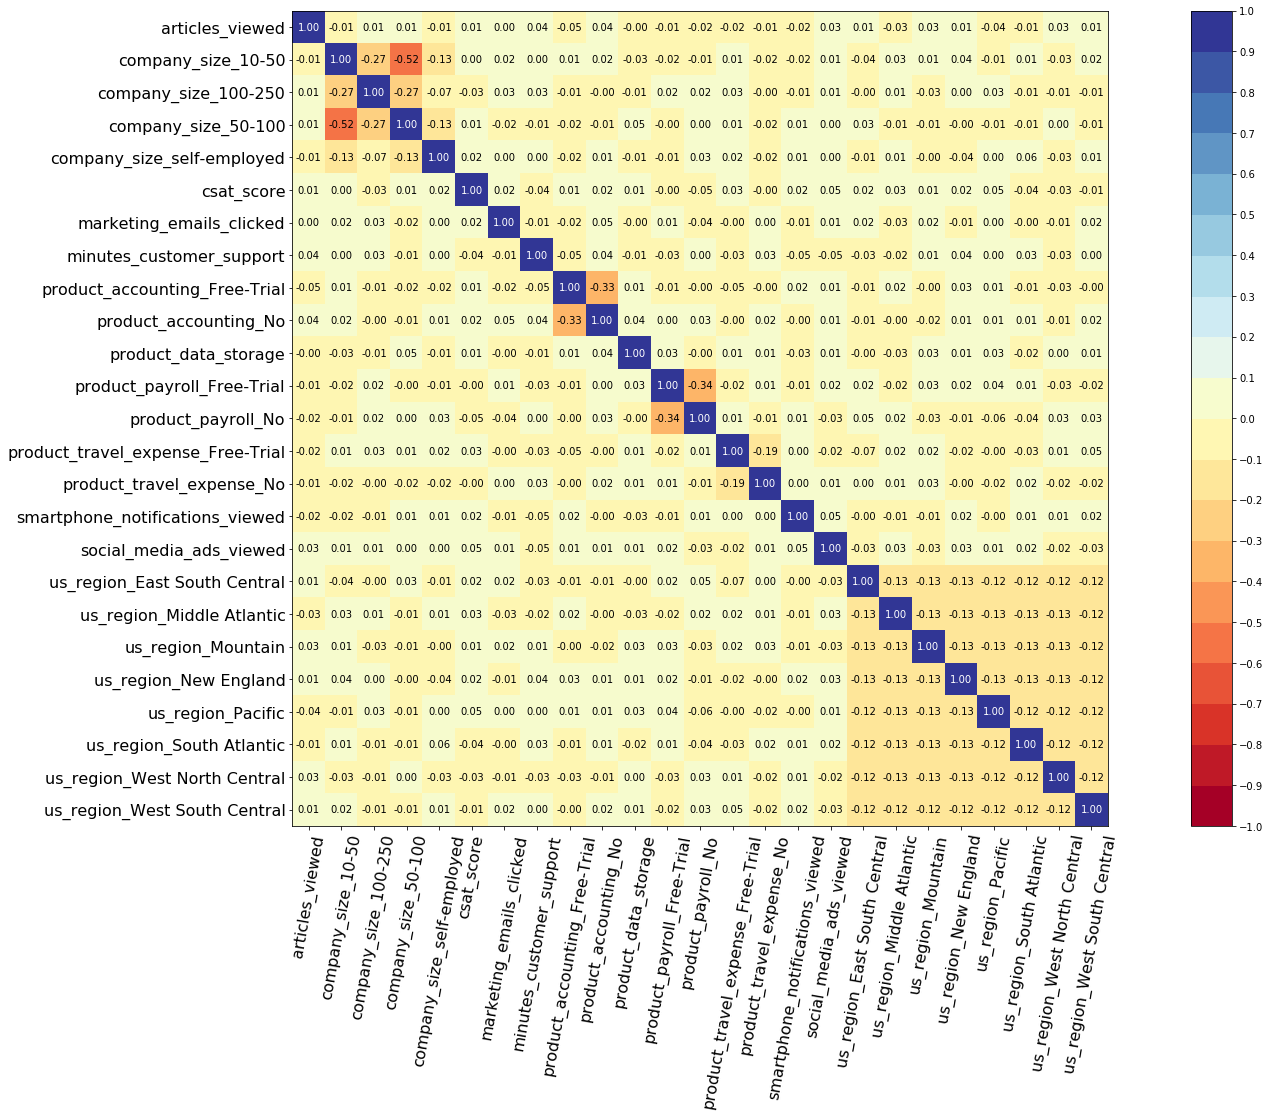

In [4]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(dataset[features], figure_size=(30,15), text_fontsize=10)

---

## 4 - Modeling

### 4.1 - Building the model
So as to perform cross-validation later on and assess the performance of the model, let's split the dataset into training and testing sets.

In [5]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( range(N), test_size = 0.35)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

Let's now fit an Extra Survival Trees model to the training set. 

*Note: The choice of the model and hyperparameters was obtained using grid-search selection, not displayed in this tutorial.*

In [6]:
from pysurvival.models.survival_forest import ExtraSurvivalTreesModel

# Fitting the model
xst = ExtraSurvivalTreesModel(num_trees=200) 
xst.fit(X_train, T_train, E_train, max_features="sqrt",
        max_depth=5, min_node_size=20, num_random_splits= 200 )

ExtraSurvivalTreesModel

### 4.2 - Variables importance
Having built a Survival Forest model allows us to compute the features importance:

In [7]:
# Computing variables importance
xst.variable_importance_table.head(5)

,feature,importance,pct_importance
0,csat_score,24.610478,0.255986
1,product_payroll_No,17.412539,0.181116
2,product_accounting_No,14.607546,0.151940
3,minutes_customer_support,7.707984,0.080174
4,product_data_storage,6.941239,0.072199


Thanks to the feature importance, we get a better understanding of what drives retention or churn. Here, the Accounting and Payroll Management products, score on the satisfaction survey as well as the amount of time spent on the phone with customer support play a primordial role.

*Note: The importance is the difference in prediction error between the perturbed and unperturbed error rate as depicted by [Breiman et al.](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)*

---

## 5 - Cross Validation
In order to assess the model performance, we previously split the original dataset into training and testing sets, so that we can now compute its performance metrics on the testing set:

### 5.1 - C-index
The C-index represents the global assessment of the model discrimination power: this is the model’s ability to correctly provide a reliable ranking of the survival times based on the individual risk scores. In general, when the C-index is close to 1, the model has an almost perfect discriminatory power; but if it is close to 0.5, it has no ability to discriminate between low and high risk subjects.

In [8]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(xst, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.85


### 5.2 - Brier Score
The Brier score measures the average discrepancies between the status and the estimated probabilities at a given time. Thus, the lower the score (usually below 0.25), the better the predictive performance. To assess the overall error measure across multiple time points, the Integrated Brier Score (IBS) is usually computed as well.

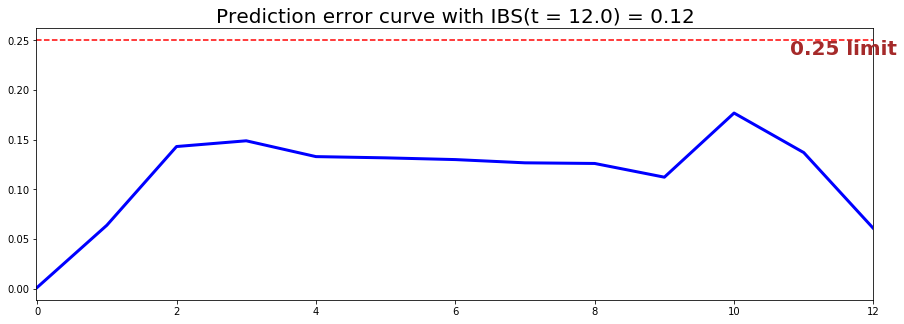

IBS: 0.12


In [9]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=12, figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

The IBS is equal to 0.1 on the entire model time axis. This indicates that the model will have good predictive abilities.

---

## 6 - Predictions
### 6.1 - Overall predictions
Now that we have built a model that seems to provide great performances, let's compare the time series of the actual and predicted number of customers who stop doing business with the SaaS company, for each time t.

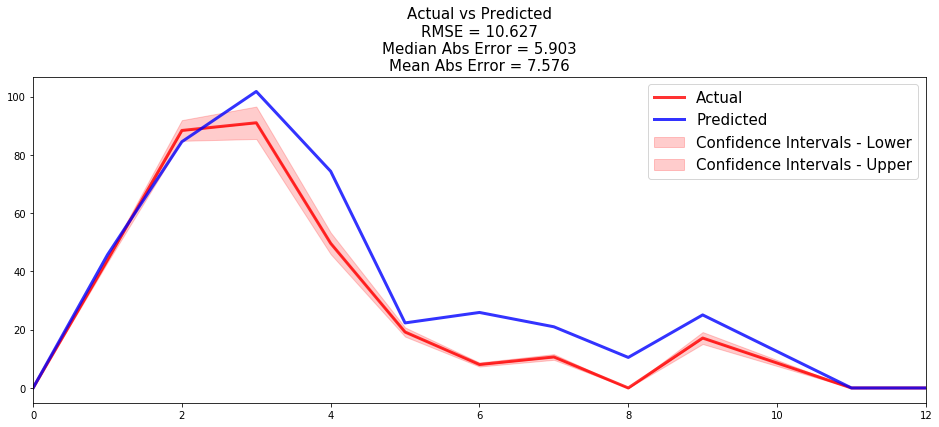

In [10]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(xst, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6), 
                            metrics = ['rmse', 'mean', 'median'])

The model provides very good results overall as on an entire 12 months window, it only makes an average absolute error of ~7 customers.

### 6.2 - Individual predictions
Now that we know that we can provide reliable predictions for an entire cohort, let's compute the probability of remaining a customer for all times t.

First, we can construct the risk groups based on risk scores distribution. The helper function `create_risk_groups`, which can be found in `pysurvival.utils.display`, will help us do that:

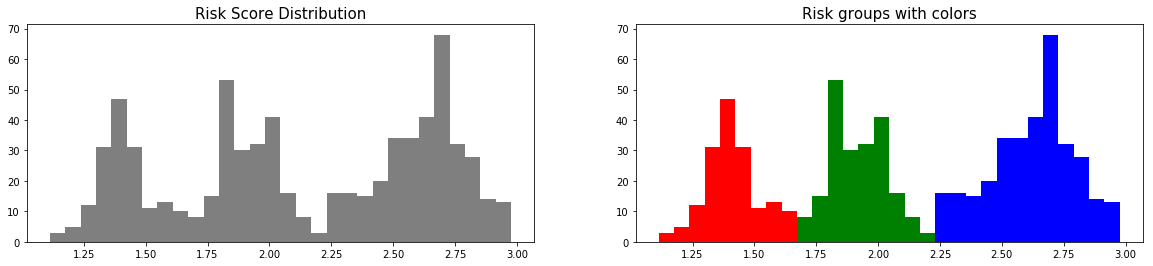

In [11]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=xst, X=X_test,
    use_log = True, num_bins=30, figure_size=(20, 4),
    low={'lower_bound':0, 'upper_bound':1.65, 'color':'red'},
    medium={'lower_bound':1.65, 'upper_bound':2.2,'color':'green'},
    high={'lower_bound':2.2, 'upper_bound':3,  'color':'blue'}
    )

Here, it is possible to distinguish 3 main groups: **low**, **medium** and **high** risk groups. Because the C-index is high, the model will be able to rank the survival times of a random unit of each group, such that $t_{high} \leq t_{medium} \leq t_{low}$.

Let's randomly select individual unit in each group and compare their likelihood to remain a customer. To demonstrate our point, we will purposely select units which experienced an event to visualize the actual time of event.

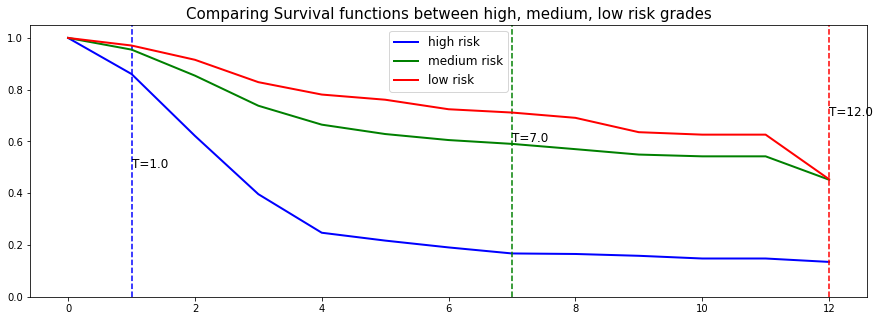

In [12]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 5))

# Selecting a random individual that experienced an event from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting an individual that experienced an event
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
    k = np.random.choice( choices, 1)[0]

    # Saving the time of event
    t = T[k]

    # Computing the Survival function for all times t
    survival = xst.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(xst.times, survival, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)),
        xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing Survival functions between {} risk grades".format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()

Here, we can see that the model manages to provide a great prediction of the event time.

---

## 7 - Conclusion
We can now save our model so as to put it in production and score future customers.

In [13]:
# Let's now save our model
from pysurvival.utils import save_model
save_model(xst, '/Users/xxx/Desktop/churn_csf.zip')

Saving the model to disk as /Users/xxx/Desktop/churn_csf.zip


In conclusion, we can see that it is possible to predict when customers will stop doing business with the company at different time points. The model will help the company be more pro-active when it comes to retaining their customers; and provide a better understanding of the reasons that drive churn.

---


## References:
* [Churn definition from hubspot.com](https://blog.hubspot.com/service/what-is-customer-churn)
* [Bain & Company - Prescription for cutting costs](http://www2.bain.com/Images/BB_Prescription_cutting_costs.pdf)
* [Random Forests. Machine Learning, 45(1), 5-32](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)